# Notebook to plot the helicity angles of $a_{0}$

In [75]:
import ROOT
import numpy as np
import my_library.common_analysis_tools as ct
import my_library.constants as constants
import my_library.kinematic_cuts as kcuts
import pandas as pd
import my_library.gluex_style

In [76]:
# TODO: angle vs cos(thetaH) for K, pi, pi, pi, p
# TODO: 2D phi(H) vs cos(thetaH) for KK
# TODO: check cut impact on acceptance filter by filter 


In [77]:
def define_a0_helicity(channel, run_period, data_type, thrown=False, filtered=True):
    if data_type not in ['signal', 'data', 'phasespace']:
        return None

    if thrown: filtered=False
    df = ct.get_dataframe(channel, run_period, data_type, thrown=thrown, filtered=filtered)

    if not thrown:
        proton = 'p'
        if channel == 'pipkmks':
            pion = 'pip1'
            kaon = 'km'
        else:
            pion = 'pim1'
            kaon = 'kp'
    else: 
        proton = 'Proton'
        if channel == 'pipkmks':
            pion = 'PiPlus1'
            kaon = 'KMinus'
            ks = 'PiPlus2_{0} + PiMinus_{0}'
        else:
            pion = 'PiMinus1'
            kaon = 'KPlus'
            ks = 'PiMinus2_{0} + PiPlus_{0}'
        df = df.Define('ks_px', ks.format('px'))
        df = df.Define('ks_py', ks.format('py'))
        df = df.Define('ks_pz', ks.format('pz'))
        df = df.Define('ks_E', ks.format('E'))
        df = df.Define('ks_m', 'sqrt(ks_E*ks_E - ks_px*ks_px - ks_py*ks_py - ks_pz*ks_pz)')

    # define kk 
    df = df.Define('kk_px', f'{kaon}_px + ks_px')
    df = df.Define('kk_py', f'{kaon}_py + ks_py')
    df = df.Define('kk_pz', f'{kaon}_pz + ks_pz')
    df = df.Define('kk_E', f'{kaon}_E + ks_E')
    # define beam/target CM frame
    df = df.Define("beam_p4", "ROOT::Math::PxPyPzEVector(0.0, 0.0, e_beam, e_beam)")
    df = df.Define("target_p4", "ROOT::Math::PxPyPzEVector(0.0, 0.0, 0.0, 0.938272)")
    # cm_boost_vector is a LorentzVector that would bring the beam/target system to the CM frame
    df = df.Define('cm_boost_vector', '(beam_p4 + target_p4).BoostToCM()')
    # recoil proton, kkpi, kk, pion lab frame vectors
    df = df.Define('p_p4', f'ROOT::Math::PxPyPzEVector({proton}_px, {proton}_py, {proton}_pz, {proton}_E)')
    df = df.Define(f'{channel}_p4', f'ROOT::Math::PxPyPzEVector({channel}_px, {channel}_py, {channel}_pz, {channel}_E)')
    df = df.Define('kk_p4', 'ROOT::Math::PxPyPzEVector(kk_px, kk_py, kk_pz, kk_E)')
    df = df.Define(f'{pion}_p4', f'ROOT::Math::PxPyPzEVector({pion}_px, {pion}_py, {pion}_pz, {pion}_E)')
    # boosting to CM framef
    df = df.Define('cm_boost', "ROOT::Math::Boost(cm_boost_vector)")
    df = df.Define('p_p4_cm', 'cm_boost(p_p4)')
    df = df.Define(f'{channel}_p4_cm', f'cm_boost({channel}_p4)')
    df = df.Define('kk_p4_cm', 'cm_boost(kk_p4)')
    df = df.Define(f'{pion}_p4_cm', f'cm_boost({pion}_p4)')
    df = df.Define('beam_p4_cm', 'cm_boost(beam_p4)')
    df = df.Define('beam_pz_cm', 'beam_p4_cm.Pz()')
    df = df.Define('target_p4_cm', 'cm_boost(target_p4)')
    df= df.Define('target_pz_cm', 'target_p4_cm.Pz()')
    # define f1 rest frame and boost into it
    df = df.Define('f1_rest_boost_vector', f'{channel}_p4_cm.BoostToCM()')
    df = df.Define('f1_rest_boost', 'ROOT::Math::Boost(f1_rest_boost_vector)')
    df = df.Define('kk_p4_rest', 'f1_rest_boost(kk_p4_cm)')
    df = df.Define(f'{pion}_p4_rest', f'f1_rest_boost({pion}_p4_cm)')
    df = df.Define('p_p4_rest', 'f1_rest_boost(p_p4_cm)')
    # define coordinate system
    df = df.Define('yhat', f'beam_p4_cm.Vect().Cross({channel}_p4_cm.Vect()).Unit()')
    df = df.Define('zhat', '-p_p4_rest.Vect().Unit()')
    df = df.Define('xhat', 'yhat.Cross(zhat)')
    # get helicity angles 
    df = df.Define('kk_rest_p3', 'kk_p4_rest.Vect()')
    df = df.Define('kk_helicty_p3', 'ROOT::Math::XYZVector(kk_rest_p3.Dot(xhat), kk_rest_p3.Dot(yhat), kk_rest_p3.Dot(zhat))')
    df = df.Define('kk_helicity_costheta', 'kk_helicty_p3.Z()/sqrt(kk_helicty_p3.Mag2())')

    return df

In [78]:
ROOT.EnableImplicitMT(12)
ROOT.gStyle.SetOptStat(0)

In [79]:
channel = 'pipkmks'
# channel = 'pimkpks'
run_period = 'fall'

if channel == 'pipkmks':
    cut = kcuts.KSTAR_ALL_CUT_PIPKMKS
elif channel == 'pimkpks':
    cut = kcuts.KSTAR_ALL_CUT_PIMKPKS

In [80]:
if channel == 'pipkmks':
    signal_region = kcuts.F1_SIGNAL_REGION_PIPKMKS
else:
    signal_region = kcuts.F1_SIGNAL_REGION_PIMKPKS

df_data = define_a0_helicity(channel, run_period, 'data').Filter(cut).Filter(signal_region)
df_signal = define_a0_helicity(channel, run_period, 'signal').Filter(cut).Filter(signal_region)
df_thrown = define_a0_helicity(channel, run_period, 'signal', thrown=True, filtered=False).Filter(signal_region)


In [81]:
# signal_region = f'{channel}_m < 1.35 && {channel}_m > 1.2'
x_low, x_high = -1.1, 1.1
nbin = int((x_high - x_low)/0.1)

hist_full_range_data = df_data.Histo1D(('hist_full_range_data', 'Cos(#Theta_{H}) for 1.2 < M(KK#pi) < 1.35', nbin, x_low, x_high), 'kk_helicity_costheta')#.GetValue()
hist_full_range_phasespace = df_signal.Histo1D(('hist_full_range_phasespace', 'hist_full_range_phasespace', nbin, x_low, x_high), 'kk_helicity_costheta')#.GetValue()
hist_full_range_thrown = df_thrown.Histo1D(('hist_full_range_thrown', 'hist_full_range_thrown', nbin, x_low, x_high), 'kk_helicity_costheta')#.GetValue()
good_acceptance_region = 'kk_helicity_costheta < 0.699999'

# df_data = df_data.Filter(good_acceptance_region)
# df_signal = df_signal.Filter(good_acceptance_region)
# df_thrown = df_thrown.Filter(good_acceptance_region)

hist_1285_kk_data = df_data.Filter(good_acceptance_region).Histo1D(('1285_kk_costheta_data', 'Cos(#Theta_{H}^{a0}) for f_{1}(1285) Region', nbin, x_low, x_high), 'kk_helicity_costheta')#.GetValue()
hist_1285_kk_phasespace = df_signal.Filter(good_acceptance_region).Histo1D(('1285_kk_costheta_phasespace', '1285_kk_costheta_phasespace', nbin, x_low, x_high), 'kk_helicity_costheta')#.GetValue()
hist_1285_kk_thrown = df_thrown.Filter(good_acceptance_region).Histo1D(('1285_kk_costheta_thrown', '1285_kk_costheta_thrown', nbin, x_low, x_high), 'kk_helicity_costheta')#.GetValue()

df_data.Count().GetValue()
df_signal.Count().GetValue()
df_thrown.Count().GetValue()


84043257

In [82]:
hist_full_range_data.Sumw2()
hist_full_range_phasespace.Sumw2()
hist_full_range_thrown.Sumw2()

acceptance_full_range = hist_full_range_phasespace.Clone('acceptance_full_range')
acceptance_full_range.Divide(hist_full_range_thrown.GetPtr())

hist_full_range_data.Divide(acceptance_full_range)

True

In [83]:
c1 = ROOT.TCanvas('c1', 'c1', 800, 600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


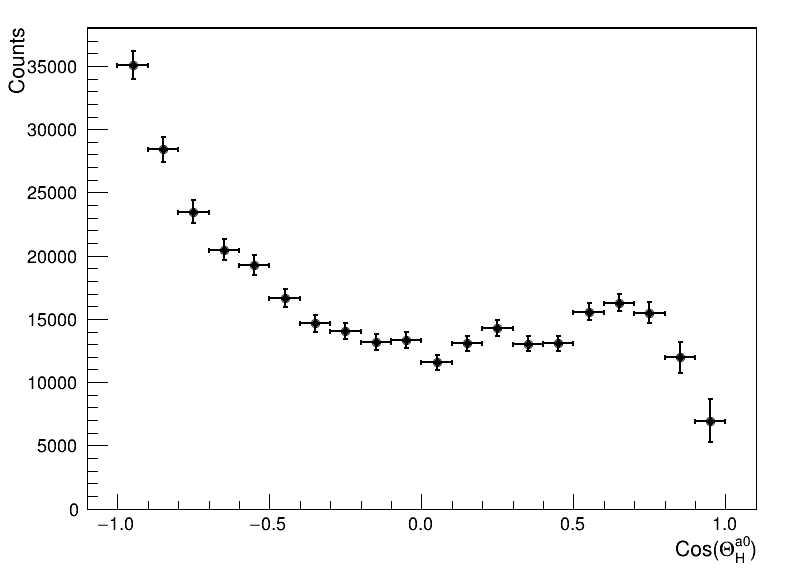

In [84]:
c1.Clear()

# hist_full_range_data.SetTitle('Cos(#Theta_{H}) for 1.2 < M(KK#pi) < 1.35')
hist_full_range_data.GetXaxis().SetTitle('Cos(#Theta_{H}^{a0})')
hist_full_range_data.GetYaxis().SetTitle('Counts')
hist_full_range_data.GetYaxis().SetTitleOffset(1.4)
hist_full_range_data.SetLineColor(ROOT.kBlack)
hist_full_range_data.SetMarkerStyle(20)

hist_full_range_data.Draw('E1')
c1.Update()
c1.Draw()

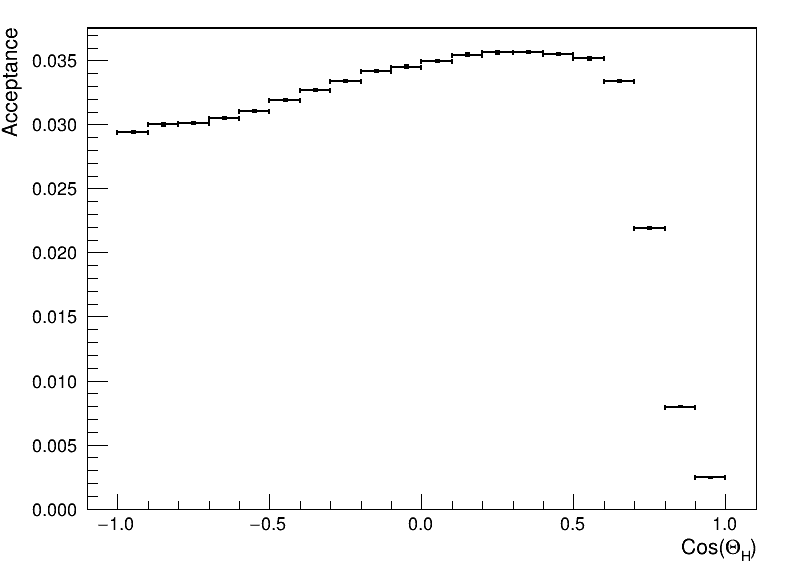

In [85]:
acceptance_full_range.SetTitle('Acceptance for 1.2 < M(KK#pi) < 1.35')
acceptance_full_range.GetXaxis().SetTitle('Cos(#Theta_{H})')
acceptance_full_range.GetYaxis().SetTitle('Acceptance')
acceptance_full_range.GetYaxis().SetTitleOffset(1.5)

acceptance_full_range.Draw('E1')
c1.Update()
c1.Draw()

In [86]:
hist_1285_kk_data.SetLineColor(ROOT.kBlack)
hist_1285_kk_phasespace.SetLineColor(ROOT.kRed)
hist_1285_kk_thrown.SetLineColor(ROOT.kViolet)

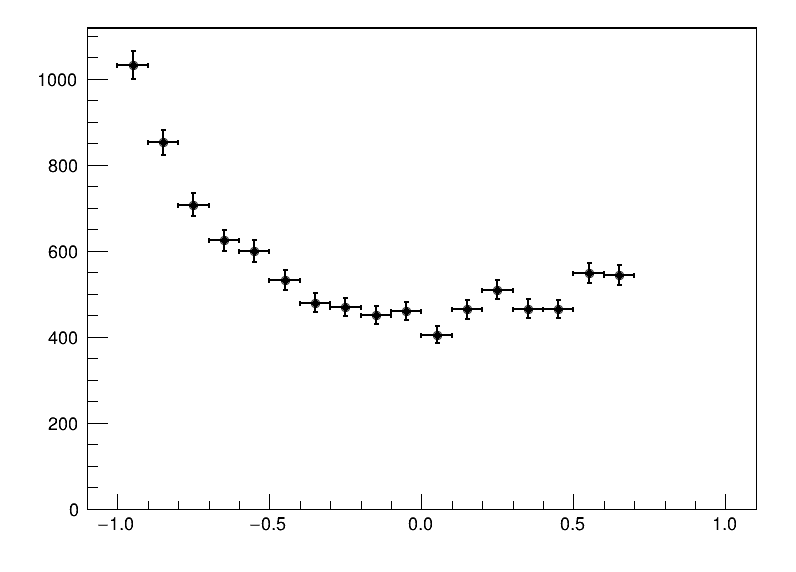

In [87]:
hist_1285_kk_data.SetMarkerStyle(20)
hist_1285_kk_data.Draw('E1')
# hist_1285_kk_thrown.Draw('E')
# hist_1285_kk_phasespace.Draw('E')
c1.Draw()

In [88]:
hist_1285_kk_data.Sumw2()
hist_1285_kk_phasespace.Sumw2()
hist_1285_kk_thrown.Sumw2()

acceptance = hist_1285_kk_phasespace.Clone('acceptance')
acceptance.Divide(hist_1285_kk_thrown.GetPtr())

for i in range(2, hist_1285_kk_data.GetNbinsX()):
    if hist_1285_kk_data.GetBinContent(i) <= 0:
        continue
    print(f'bin middle: {hist_1285_kk_data.GetBinCenter(i)} || data: {hist_1285_kk_data.GetBinContent(i)} || efficiency: {acceptance.GetBinContent(i)} || efficiency corrected: {hist_1285_kk_data.GetBinContent(i)/acceptance.GetBinContent(i)}')

hist_1285_kk_data.Divide(acceptance)


bin middle: -0.95 || data: 1032.0 || efficiency: 0.02941448304315223 || efficiency corrected: 35084.75734508115
bin middle: -0.8500000000000001 || data: 852.0 || efficiency: 0.029996770907422605 || efficiency corrected: 28403.057203373024
bin middle: -0.75 || data: 707.0 || efficiency: 0.030115045707811382 || efficiency corrected: 23476.637122174947
bin middle: -0.65 || data: 624.0 || efficiency: 0.030489725724281477 || efficiency corrected: 20465.910570755233
bin middle: -0.55 || data: 599.0 || efficiency: 0.03107071690979123 || efficiency corrected: 19278.602477667286
bin middle: -0.45 || data: 531.0 || efficiency: 0.031897061255052955 || efficiency corrected: 16647.301635534903
bin middle: -0.35000000000000003 || data: 479.0 || efficiency: 0.03267339850775487 || efficiency corrected: 14660.244170385633
bin middle: -0.25000000000000006 || data: 469.0 || efficiency: 0.03337521597593565 || efficiency corrected: 14052.34352155685
bin middle: -0.15000000000000008 || data: 451.0 || effici

True

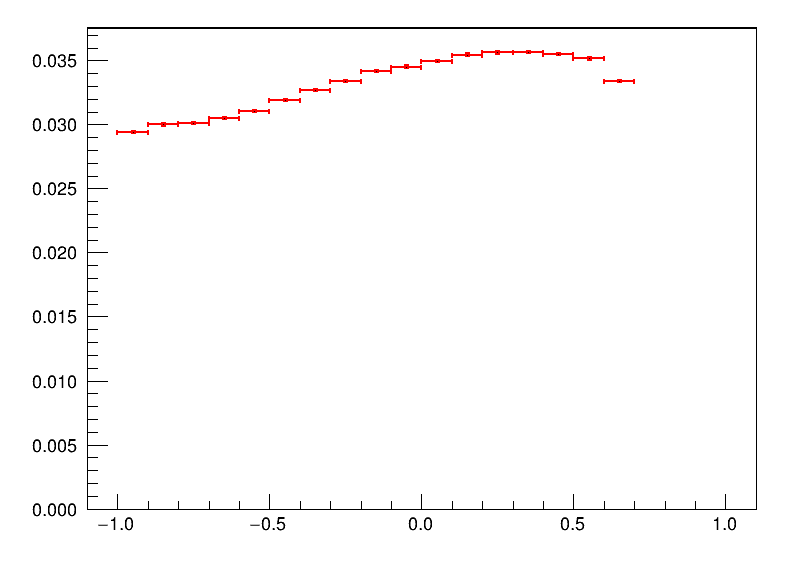

In [89]:
acceptance.Draw('E1')
c1.Draw()

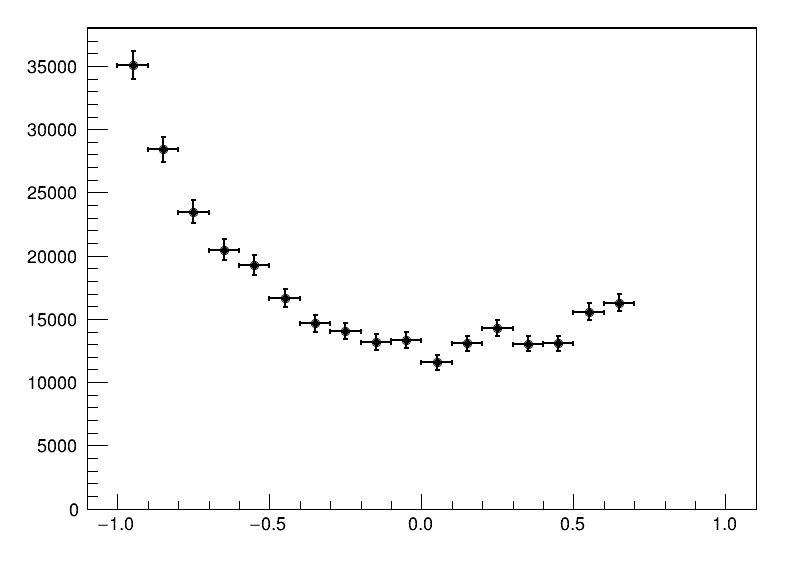

In [90]:
hist_1285_kk_data.Draw("E1")
c1.Draw()

In [91]:
func_eta = ROOT.TF1("func_eta", "[0]", -1, 1)
func_f1 = ROOT.TF1("func_f1", "[0]*cos(x)*cos(x) + [1]*sin(x)*sin(x)", -1, 1)

func_eta.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
func_f1.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))


# func_eta.SetParameter(0, 600)
# func_f1.SetParameter(0, -600)
# func_f1.SetParameter(1, 200)

In [92]:
hist_1285_kk_data.Fit(func_eta, "BS+")
hist_1285_kk_data.Fit(func_f1, "BS+")

 FCN=768.714 FROM MIGRAD    STATUS=CONVERGED      14 CALLS          15 TOTAL
                     EDM=1.34985e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.56577e+04   1.67050e+02   2.26099e+00  -3.11036e-06
 FCN=160.327 FROM MIGRAD    STATUS=CONVERGED      32 CALLS          33 TOTAL
                     EDM=3.289e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.15465e+04   2.35983e+02   1.21795e+00   4.08375e-13
   2  p1           3.62566e+04   8.51669e+02   4.36547e+00   4.88293e-14


In [93]:
chi2_per_ndf_eta = func_eta.GetChisquare()/func_eta.GetNDF()
chi2_per_ndf_f1 = func_f1.GetChisquare()/func_f1.GetNDF()

print(f'chi2 per ndf for eta: {chi2_per_ndf_eta}')
print(f'chi2 per ndf for f1: {chi2_per_ndf_f1}')

chi2 per ndf for eta: 48.04462772259241
chi2 per ndf for f1: 10.688435922909218


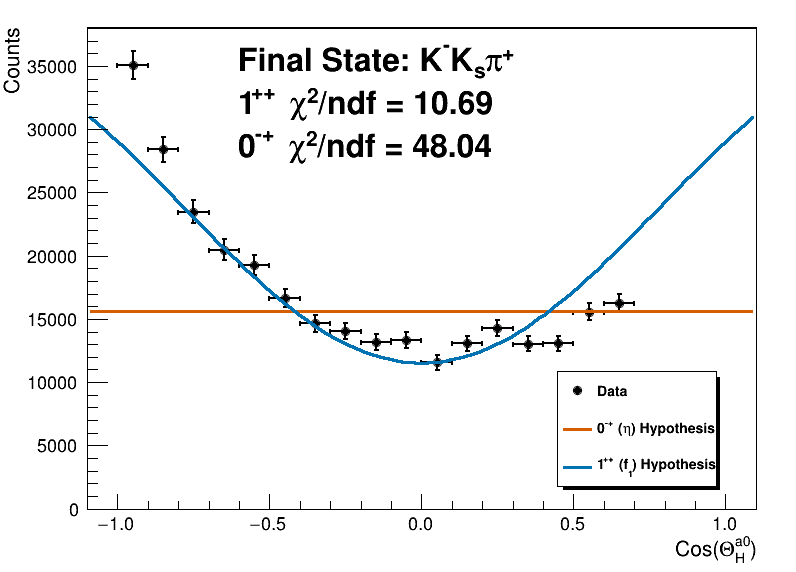

In [94]:
hist_1285_kk_data.GetXaxis().SetTitle('Cos(#Theta_{H}^{a0})')
hist_1285_kk_data.GetYaxis().SetTitle('Counts')
hist_1285_kk_data.GetYaxis().SetTitleOffset(1.5)
hist_1285_kk_data.SetMarkerStyle(20)
hist_1285_kk_data.Draw("E1")

legend = ROOT.TLegend(0.7, 0.15, 0.9, 0.35)
legend.AddEntry(hist_1285_kk_data.GetPtr(), 'Data', 'p')
legend.AddEntry(func_eta, '0^{-+} (#eta) Hypothesis', 'l')
legend.AddEntry(func_f1, '1^{++} (f_{1}) Hypothesis', 'l')

if channel == 'pipkmks':
    final_state_str = 'Final State: K^{-}K_{s}#pi^{+}'
else:
    final_state_str = 'Final State: K^{+}K_{s}#pi^{-}'
    

hel_fit_latex = ROOT.TLatex()
hel_fit_latex.SetTextSize(0.06)
hel_fit_latex.DrawLatexNDC(0.3, 0.875, final_state_str )
hel_fit_latex.DrawLatexNDC(0.3, 0.8, '1^{++} #chi^{2}/ndf = ' + '{:.2f}'.format(chi2_per_ndf_f1))
hel_fit_latex.DrawLatexNDC(0.3, 0.725, '0^{-+} #chi^{2}/ndf = ' + '{:.2f}'.format(chi2_per_ndf_eta))
legend.Draw()

c1.Draw()

In [ ]:
hist2d = df_data.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

In [ ]:
hist2d.Draw('COLZ')
c1.Draw()

In [ ]:
hist_signal_costhets = df_signal.Filter(f'{channel}_m < 1.35 && {channel}_m > 1.24').Histo1D(('costheta-kk_signal', 'Cos(#Theta^{H}_{KK})', 25, -1.1, 1.1), 'kk_helicity_costheta')
hist_signal_kkpi = df_signal.Filter(f'{channel}_m < 1.35 && {channel}_m > 1.24').Histo1D(('kkpi_signal', 'M(KK#pi)', 50, 1.24, 1.35), f'{channel}_m')
hist_signal_2d = df_signal.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

In [ ]:
hist_thrown_costhets = df_thrown.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('costheta-kk_signal', 'Cos(#Theta^{H}_{KK})', 25, -1.1, 1.1), 'kk_helicity_costheta')
hist_thrown_kkpi = df_thrown.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('kkpi_signal', 'M(KK#pi)', 50, 1.24, 1.35), f'{channel}_m')
hist_thrown_2d = df_thrown.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

In [ ]:
c2 = ROOT.TCanvas('c2', 'c2', 1200, 800)
c2.Divide(3, 1)

c2.cd(1)
hist_signal_costhets.Draw('E')
c2.cd(2)
hist_signal_kkpi.Draw('E')
c2.cd(3)
hist_signal_2d.Draw('COLZ')
c2.Draw()

In [ ]:
c2.cd(1)
hist_thrown_costhets.Draw('E')
c2.cd(2)
hist_thrown_kkpi.Draw('E')
c2.cd(3)
hist_thrown_2d.Draw('COLZ')
c2.Draw()

In [ ]:
c1.cd()
hist_eff_test = hist_1285_kk_phasespace.Clone('eff_test')
hist_eff_test.Divide(acceptance)

hist_eff_test.Draw('E')
c1.Draw()